# Mask R-CNN - Prediction on Lung Panel 18 data


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

## Load library

In [1]:
from mrcnn.main import *
from mrcnn.utils import *
# Set path to Mask RCNN folder
ROOT_DIR = os.path.abspath(r"C:\Users\tr248228\MaskRCNN_cell")
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs4")
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline 
from mrcnn.config import Config

Using TensorFlow backend.


## Load pretrained weights

In [2]:
model_path = r"C:\Users\tr248228\MaskRCNN_cell\logs4\cell20220130T2007\mask_rcnn_cell_0030.h5"

## Configuration for the prediction

Important parameters:

    DETECTION_MAX_INSTANCES: max number of cells can be predicted in the image
    RPN_ANCHOR_SCALES: Size of target cells
    

In [3]:
class InferenceConfig(CellConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_RESIZE_MODE = "pad64" # 'none' #
    DETECTION_MAX_INSTANCES = 3500 #3000
    DETECTION_MIN_CONFIDENCE = 0.5
    DETECTION_NMS_THRESHOLD = 0.20
#     ROI_POSITIVE_RATIO = 0.8
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)
    #MEAN_PIXEL = np.array([40,15,30])
    
    POST_NMS_ROIS_INFERENCE=12000 #15000

## Load Model

In [4]:
inference_config = InferenceConfig()
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)


model.load_weights(model_path, by_name=True)

## Prediction on training data

In [5]:
# train_images = sorted(glob.glob('./train/*crop.png'))
# train_masks = sorted(glob.glob('./train/*label.png'))

train_images = sorted((glob.glob("trainingData2/*Nuclei.jpg")))
train_masks = sorted((glob.glob("trainingData1/*Detections.tiff")))

# train_images = sorted((glob.glob("valData2/*Nuclei.jpg")))
# train_masks = sorted((glob.glob("valData1/*Detections.tiff")))
train_images

['trainingData2\\B32Nuclei.jpg',
 'trainingData2\\D35Nuclei.jpg',
 'trainingData2\\F11Nuclei.jpg',
 'trainingData2\\H32Nuclei.jpg',
 'trainingData2\\K27Nuclei.jpg',
 'trainingData2\\L28Nuclei.jpg',
 'trainingData2\\S10Nuclei.jpg',
 'trainingData2\\T37Nuclei.jpg',
 'trainingData2\\W14Nuclei.jpg']

Processing 1 images
image                    shape: (298, 311, 3)         min:    0.00000  max:  246.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min:    0.00000  max:  246.00000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  320.00000  int32
anchors                  shape: (1, 25575, 4)         min:   -0.28373  max:    1.08310  float32


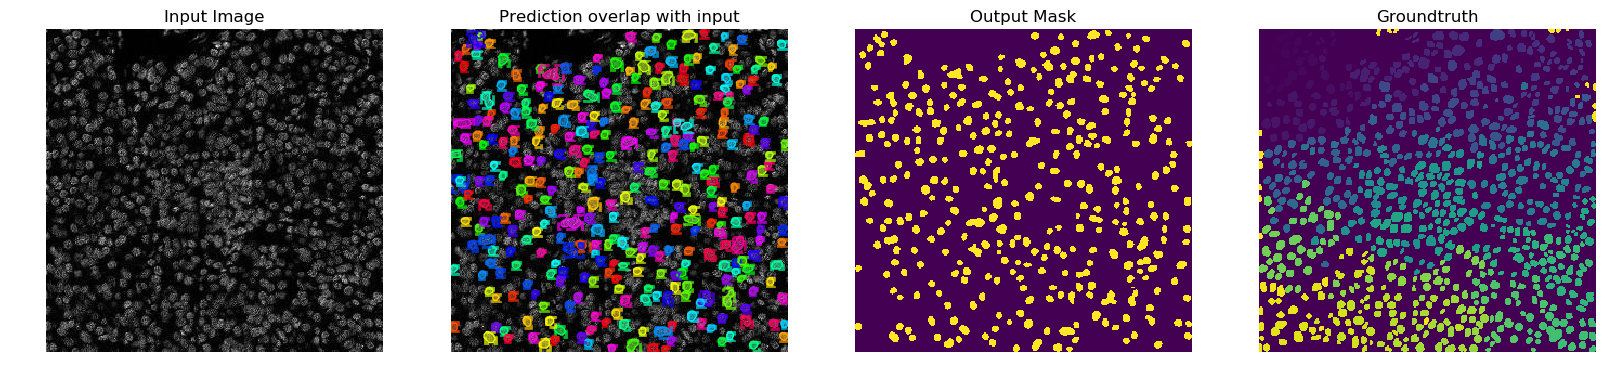

In [6]:
example_index=4
im = imageio.imread(train_images[example_index])
# im = np.reshape(im, (1, im.shape[0], im.shape[1]))
r = model.detect([im], verbose=1)[0]
plt.figure(figsize=(20,5),dpi=100)
ax1=plt.subplot(1,4,1)
plt.imshow(im)
plt.title('Input Image')
plt.axis('off')
ax2=plt.subplot(1,4,2)
visualize.display_instances_new(im, r['rois'], r['masks'], r['class_ids'], r['scores'], ax=ax2)
plt.title('Prediction overlap with input')
plt.axis('off')
plt.subplot(1,4,3)
mask = np.zeros(im.shape[:2])
for x in range(r['masks'].shape[2]):
    mask+= (r['masks'][:,:,x])
plt.imshow(mask>0)
plt.title('Output Mask')
plt.axis('off')
plt.subplot(1,4,4)
plt.imshow(imageio.imread(train_masks[example_index]))
plt.title('Groundtruth')
plt.axis('off')
plt.show()


In [ ]:
print(r.keys())
print('You have ' + str(len(r['masks'])) + 'nuclei detected')
print(r['masks'])

In [ ]:
r['scores']

## Prediction on test data (less than 3000 cells per image)

In [12]:
test_images = sorted(glob.glob("valData2/*Nuclei.jpg"))

Wall time: 0 ns
Processing 1 images
image                    shape: (282, 270, 3)         min:    0.00000  max:  242.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min:    0.00000  max:  242.00000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  320.00000  int32
anchors                  shape: (1, 25575, 4)         min:   -0.28373  max:    1.08310  float32
Processing 1 images
image                    shape: (311, 320, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min:    0.00000  max:  255.00000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  320.00000  int32
anchors                  shape: (1, 25575, 4)         min:   -0.28373  max:    1.08310  float32


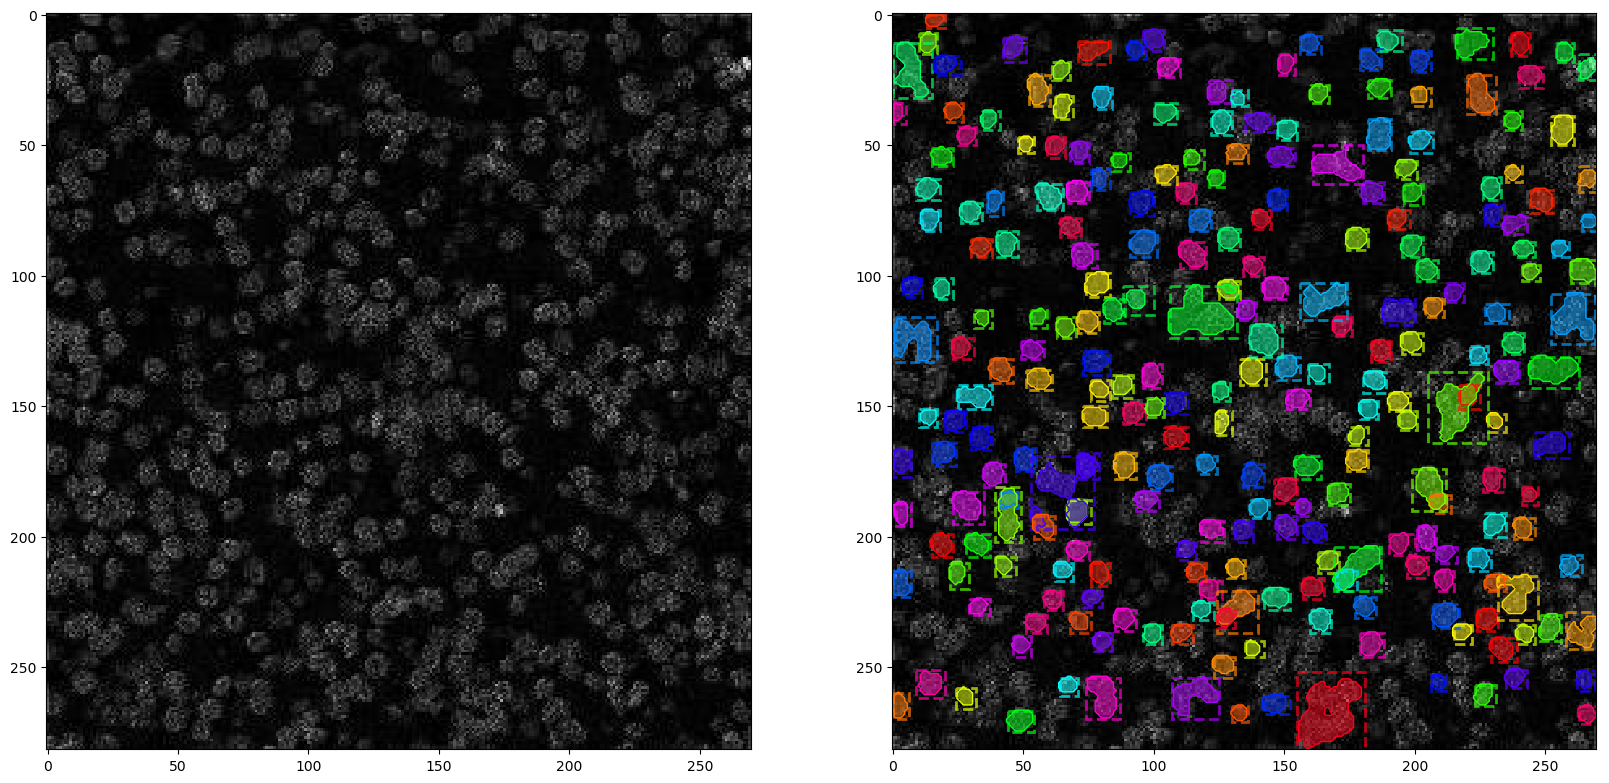

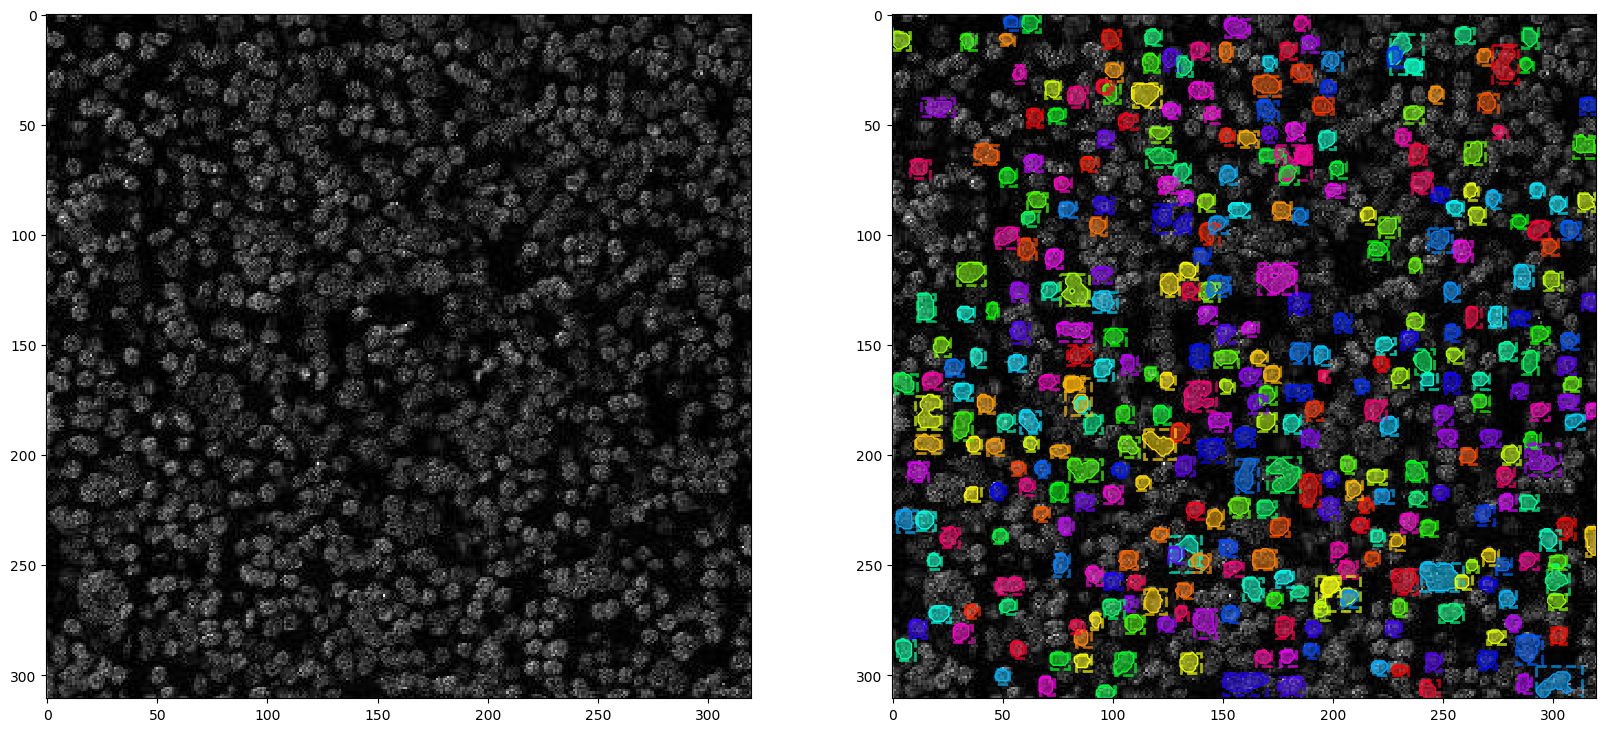

In [13]:
%time
for image in test_images:
    plt.figure(figsize=(20,10),dpi=100)
    im = imageio.imread(image)
    plt.subplot(1,2,1)
    plt.imshow(im)
    ax2=plt.subplot(1,2,2)
    r=results = model.detect([im], verbose=1)[0]
    visualize.display_instances_new(im, r['rois'], r['masks'], r['class_ids'], r['scores'], ax=ax2)
    

## Prediction on test data (large number of cells - stitching used)

In [9]:
output_dir = '/home/ubuntu/github/MaskRCNN/data/segmentation/'
rgb_images = sorted(glob.glob('/home/ubuntu/github/MaskRCNN/data/RGB_2/*.png')) 
rgb_images_colormap2 = sorted(glob.glob('./data/RGB_2/*.png')) 


In [12]:
## unit prediction image size
x_size = 512 #512
y_size=704 #704

to_output_image = True
for e,in_image in enumerate(rgb_images):
    out_image = '.'.join('/'.join(in_image.split('/')[-2:]).split('.')[:-1])
    os.makedirs(os.path.dirname(output_dir+out_image), exist_ok=True)
    test_image = imageio.imread(in_image)
    test_image_ori = imageio.imread(rgb_images_colormap2[e])

    test_x_offset = 0
    test_y_offset = 0
    imagesize= test_image.shape

    x_size = 512 #512
    y_size=704 #704
    x_patch = imagesize[0]//x_size +1
    y_patch = imagesize[1]//y_size +1

    height, width = test_image.shape[:2]
    whole_img = np.zeros([height,width,3])
    score_mask = []
    sub_id=1
    mask_name = output_dir+out_image+'.txt'
    score_name = output_dir+out_image+'_score.txt'
    openwrite = open(mask_name, 'w+')
    openscore = open(score_name, 'w+')
    openwrite.writelines(str(height)+','+str(width)+'\n')
    for i in range(x_patch):
        for j in range(y_patch):
            real_mask=[]

            test_x_offset = x_size*i
            test_y_offset = y_size*j
            test_image_rgb = test_image[test_x_offset:test_x_offset+x_size,test_y_offset:test_y_offset+y_size,:]

            test_image_rgb_ori = test_image_ori[test_x_offset:test_x_offset+x_size,test_y_offset:test_y_offset+y_size,:]

            r = model.detect([test_image_rgb], verbose=0)[0]

            if to_output_image:
                output_image = visualize.display_instances(test_image_rgb, r['rois'], r['masks'], r['class_ids'], r['scores'],show_bbox=None,figsize=(30, 30))
                whole_img[test_x_offset:test_x_offset+output_image.shape[0],test_y_offset:test_y_offset+output_image.shape[1],:]=output_image

            #print(test_image_rgb.shape,output_image.shape)
            for index in range(r['masks'].shape[2]):
                mask = r['masks'][:,:,index]
                if np.sum(mask)<=25:
                    continue
                temp_mask = np.zeros([height,width])
                temp_mask[test_x_offset:test_x_offset+test_image_rgb.shape[0],test_y_offset:test_y_offset+test_image_rgb.shape[1]]=mask
                real_mask.append(temp_mask)
                score_mask.append(r['scores'][index])
            mask_image = output_dir+out_image+'-'+str(sub_id)+'.png'
            visualize.save_instances(test_image_rgb_ori, r['rois'], r['masks'], r['class_ids'],class_names=['BG', 'cell'],title=mask_image,show_bbox=None,show_mask=None)
            sub_id+=1
            if len(real_mask)!=0:
                real_mask=np.asarray(real_mask) #.swapaxes(1,2).T
                x=mask_to_rle_overlap(e, (real_mask))
                openwrite.writelines(x + '\n')

    np.savetxt(openscore, np.array(score_mask), delimiter=",")

    openwrite.close()
    openscore.close()


/home/ubuntu/github/MaskRCNN/data/RGB_2/Sample1 _[x1,y1]_component_data.png
RGB_2/Sample1 _[x1,y1]_component_data
604
767
913
591
/home/ubuntu/github/MaskRCNN/data/RGB_2/Sample2 _[x2,y2]_component_data.png
RGB_2/Sample2 _[x2,y2]_component_data
829
737
830
793
